# Aquire Data

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from math import sqrt
from statsmodels.formula.api import ols

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from env import host, user, password
import acquire
import prepare

sql_query = '''select *
    from  properties_2017
    join predictions_2017 using(parcelid)
    where transactiondate between "2017-05-01" and "2017-08-31"
        and propertylandusetypeid between 260 and 266
            or propertylandusetypeid between 273 and 279
            and not propertylandusetypeid = 274
        and unitcnt = 1;
    '''
connection = f'mysql+pymysql://{user}:{password}@{host}/zillow'
df = pd.read_sql(sql_query, connection)

# Lets Clean the Data

df.head()

df.info()

df.describe()

df = df.dropna(axis=1,thresh=35000)

df.head()

df.info()

- What I want to do on top of that:
    - Delete columns:
        - `calculatedbathnbr`
            - because we already have the finished number of bathrooms
        - `finishedsquarefeet12`
            - because we have our finished square feet already
        - `propertycountylandusecode`
            - because we have the id for this already
        - `propertyzoningdesc`
            - because it is not that helpful
        - `logerror`
            - because logerror is an unknown feature in data dictonary
        - `transactiondate`
            - because it is not that helpful
        - `yearbuilt`
            - because it would not be read as a year but as a numeric value
        - `taxvaluedollarcnt`
            - using this would be cheating
        - `landtaxvaluedollarcnt`
            - using this would be cheating
        - `taxvaluedollarcnt`
            - using this would be cheating
        - `rawcensustractandblock`
            - because it is uneeded
        - `censustractandblock`
            - because it is uneeded
    - Rename columns:
        - `bathroomcnt` to "bathrooms"
        - `bedroomcnt` to "bedrooms"
        - `calculatedfinishedsquarefeet` to "house_square_feet"
        - `fullbathcnt` to "full_baths"
        - `regionidzip` to "zip_code"
        - `regionidcity` to "city"
        - `regionidcounty` to "county"

df = df.drop(['calculatedbathnbr', 'finishedsquarefeet12', 
             'propertycountylandusecode', 'logerror', 'transactiondate',  
             'yearbuilt', 'landtaxvaluedollarcnt', 
              'rawcensustractandblock', 'censustractandblock', 
              'structuretaxvaluedollarcnt', 'parcelid', 'id'], axis=1)
df.head()

df = df.rename(columns={'bathroomcnt':'bathrooms', 'bedroomcnt':'bedrooms', 
                       'calculatedfinishedsquarefeet':'square_feet', 
                       'fullbathcnt':'full_baths', 'regionidzip':'zip_code', 
                       'regionidcity':'city', 'regionidcounty':'county',
                       'taxvaluedollarcnt':'appraised_value', 
                        'propertylandusetypeid':'house_type'})
df.head()

df.info()

df.isnull().sum()

df = df.dropna()
df.info()

#this ended up dropping from 38582 to 37712
    # we lost 870 rows by dropping
    

In [4]:
df = acquire.acquire_zillow()
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,None,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,None,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,None,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,None,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38582 entries, 0 to 38581
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38582 non-null  int64  
 1   id                            38582 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38582 non-null  float64
 6   bedroomcnt                    38582 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38438 non-null  float64
 10  decktypeid                    331 non-null    float64
 11  finishedfloor1squarefeet      3338 non-null   float64
 12  calculatedfinishedsquarefeet  38474 non-null  float64
 13  f

In [6]:
df.describe()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,logerror
count,3.858200e+04,3.858200e+04,12224.000000,101.000000,27.000000,38582.000000,38582.000000,23706.000000,38438.000000,331.0,...,84.0,3.853800e+04,3.858100e+04,38582.0,3.858100e+04,38581.000000,1268.000000,3.843800e+04,38582.000000,38582.000000
mean,1.310076e+07,1.500629e+06,1.900196,7.564356,639.703704,2.274804,3.012234,6.610394,2.282923,66.0,...,1.0,1.908288e+05,4.968970e+05,2016.0,3.062809e+05,6047.039531,14.070978,6.050143e+13,52114.257737,0.015858
std,3.700368e+06,8.591952e+05,3.112632,3.232386,445.977907,0.949997,1.028056,1.694360,0.941981,0.0,...,0.0,2.384854e+05,6.329361e+05,0.0,4.585448e+05,7369.426329,1.482764,2.118134e+11,12046.708853,0.171989
min,1.071186e+07,3.490000e+02,1.000000,2.000000,100.000000,0.000000,0.000000,1.000000,1.000000,66.0,...,1.0,1.290000e+02,1.000000e+03,2016.0,1.000000e+03,19.920000,7.000000,6.037101e+13,625.000000,-4.453964
25%,1.154637e+07,7.601705e+05,1.000000,7.000000,349.000000,2.000000,2.000000,6.000000,2.000000,66.0,...,1.0,8.464225e+04,2.092220e+05,2016.0,8.702300e+04,2724.530000,14.000000,6.037400e+13,41834.250000,-0.023437
50%,1.260209e+07,1.507442e+06,1.000000,7.000000,604.000000,2.000000,3.000000,7.000000,2.000000,66.0,...,1.0,1.370000e+05,3.640000e+05,2016.0,2.080470e+05,4467.070000,15.000000,6.037651e+13,52150.500000,0.006787
75%,1.429667e+07,2.243124e+06,1.000000,7.000000,743.000000,3.000000,4.000000,8.000000,3.000000,66.0,...,1.0,2.200000e+05,5.779140e+05,2016.0,3.764150e+05,6988.220000,15.000000,6.059052e+13,62491.750000,0.037581
max,1.676878e+08,2.982274e+06,13.000000,21.000000,1969.000000,11.000000,12.000000,12.000000,11.000000,66.0,...,1.0,1.142179e+07,2.385837e+07,2016.0,1.635060e+07,276797.830000,15.000000,6.111009e+13,72844.000000,3.175688


In [7]:
df = prepare.clean_zillow(df)
df.head()

,bathrooms,bedrooms,square_feet,fips,full_baths,latitude,longitude,house_type,city,county,zip_code,roomcnt,appraised_value,assessmentyear,taxamount,house_age
0,2.0,3.0,1125.0,6059.0,2.0,33922098.0,-117954970.0,266.0,18874.0,1286.0,96186.0,6.0,289445.0,2016.0,3490.16,47.0
1,2.0,3.0,1316.0,6037.0,2.0,34033180.0,-118355396.0,261.0,12447.0,3101.0,95997.0,0.0,205123.0,2016.0,2627.48,98.0
2,2.0,3.0,1458.0,6037.0,2.0,34686163.0,-118113100.0,261.0,5534.0,3101.0,97318.0,0.0,136104.0,2016.0,2319.90,51.0
3,2.0,3.0,1766.0,6037.0,2.0,34073222.0,-118390965.0,266.0,10389.0,3101.0,96086.0,0.0,810694.0,2016.0,9407.01,41.0
4,1.0,2.0,1421.0,6037.0,1.0,33999877.0,-118291863.0,261.0,12447.0,3101.0,96018.0,0.0,35606.0,2016.0,543.69,110.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32542 entries, 0 to 38581
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        32542 non-null  float64
 1   bedrooms         32542 non-null  float64
 2   square_feet      32542 non-null  float64
 3   fips             32542 non-null  float64
 4   full_baths       32542 non-null  float64
 5   latitude         32542 non-null  float64
 6   longitude        32542 non-null  float64
 7   house_type       32542 non-null  float64
 8   city             32542 non-null  float64
 9   county           32542 non-null  float64
 10  zip_code         32542 non-null  float64
 11  roomcnt          32542 non-null  float64
 12  appraised_value  32542 non-null  float64
 13  assessmentyear   32542 non-null  float64
 14  taxamount        32542 non-null  float64
 15  house_age        32542 non-null  float64
dtypes: float64(16)
memory usage: 4.2 MB


In [9]:
df.describe()

,bathrooms,bedrooms,square_feet,fips,full_baths,latitude,longitude,house_type,city,county,zip_code,roomcnt,appraised_value,assessmentyear,taxamount,house_age
count,32542.000000,32542.000000,32542.000000,32542.000000,32542.000000,3.254200e+04,3.254200e+04,32542.000000,32542.000000,32542.000000,32542.000000,32542.000000,3.254200e+04,32542.0,32542.000000,32542.000000
mean,2.074642,2.824196,1517.124209,6049.755270,2.007897,3.400544e+07,-1.181973e+08,262.514351,33631.434761,2497.414787,96611.218210,1.578883,3.644769e+05,2016.0,4505.791647,52.733114
std,0.693076,0.821697,529.219531,21.420546,0.684684,2.665011e+05,3.654818e+05,2.291452,46729.766592,812.284560,3779.625867,2.803222,2.270200e+05,0.0,2670.529216,22.231937
min,1.000000,1.000000,242.000000,6037.000000,1.000000,3.333960e+07,-1.194484e+08,260.000000,3491.000000,1286.000000,95982.000000,0.000000,1.050400e+04,2016.0,19.920000,5.000000
25%,2.000000,2.000000,1130.000000,6037.000000,2.000000,3.380862e+07,-1.184099e+08,261.000000,12447.000000,1286.000000,96213.000000,0.000000,1.915722e+05,2016.0,2517.535000,36.000000
50%,2.000000,3.000000,1424.000000,6037.000000,2.000000,3.401016e+07,-1.181597e+08,261.000000,25218.000000,3101.000000,96412.000000,0.000000,3.294540e+05,2016.0,4068.840000,52.000000
75%,2.500000,3.000000,1818.000000,6059.000000,2.000000,3.417909e+07,-1.179200e+08,266.000000,45457.000000,3101.000000,96993.000000,3.000000,4.929138e+05,2016.0,5975.072500,68.000000
max,7.500000,4.000000,3130.000000,6111.000000,7.000000,3.481877e+07,-1.175724e+08,266.000000,396556.000000,3101.000000,399675.000000,11.000000,1.123324e+06,2016.0,24366.440000,143.000000


Text(0.5, 1.0, 'Zillow Correlation Heatmap of Trained Data without Scaling')

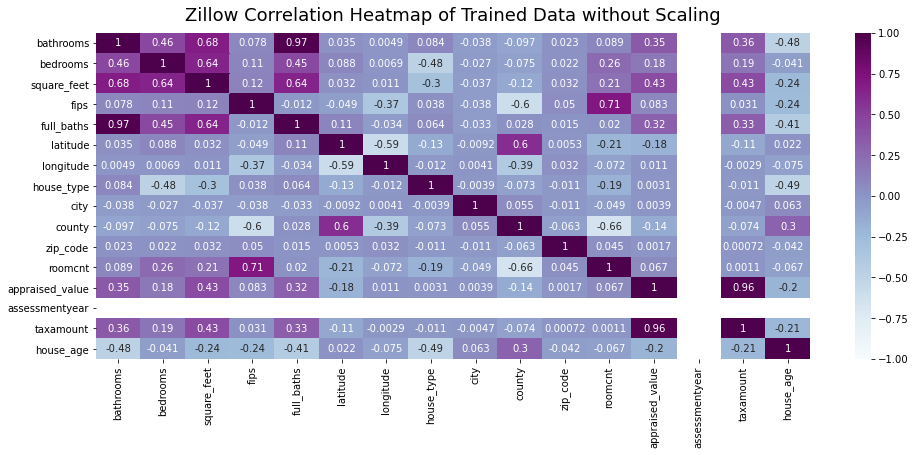

In [10]:
plt.figure(figsize=(16, 6))
corr_map = sns.heatmap(df.corr(), cmap="BuPu", vmin=-1, vmax=1, annot=True)
corr_map.set_title('Zillow Correlation Heatmap of Trained Data without Scaling', fontdict={'fontsize':18}, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

- Takeaways
    - my target is `appraised_value`
        - strongest correlations are
            - square_feet
                - 0.61
            - bathrooms
                - 0.51
            - bedrooms
                - 0.29
            - house_age
                - 0.13
            - lattitude
                - 0.11
            - house_type
                - 0.1

In [11]:
df = prepare.focused_zillow(df)
df.head()

,square_feet,bedrooms,bathrooms,city,house_type,appraised_value
0,1125.0,3.0,2.0,18874.0,266.0,289445.0
1,1316.0,3.0,2.0,12447.0,261.0,205123.0
2,1458.0,3.0,2.0,5534.0,261.0,136104.0
3,1766.0,3.0,2.0,10389.0,266.0,810694.0
4,1421.0,2.0,1.0,12447.0,261.0,35606.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32542 entries, 0 to 38581
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   square_feet      32542 non-null  float64
 1   bedrooms         32542 non-null  float64
 2   bathrooms        32542 non-null  float64
 3   city             32542 non-null  float64
 4   house_type       32542 non-null  float64
 5   appraised_value  32542 non-null  float64
dtypes: float64(6)
memory usage: 1.7 MB


In [13]:
df.describe()

,square_feet,bedrooms,bathrooms,city,house_type,appraised_value
count,32542.000000,32542.000000,32542.000000,32542.000000,32542.000000,3.254200e+04
mean,1517.124209,2.824196,2.074642,33631.434761,262.514351,3.644769e+05
std,529.219531,0.821697,0.693076,46729.766592,2.291452,2.270200e+05
min,242.000000,1.000000,1.000000,3491.000000,260.000000,1.050400e+04
25%,1130.000000,2.000000,2.000000,12447.000000,261.000000,1.915722e+05
50%,1424.000000,3.000000,2.000000,25218.000000,261.000000,3.294540e+05
75%,1818.000000,3.000000,2.500000,45457.000000,266.000000,4.929138e+05
max,3130.000000,4.000000,7.500000,396556.000000,266.000000,1.123324e+06


In [14]:
df.value_counts()

square_feet  bedrooms  bathrooms  city     house_type  appraised_value
680.0        1.0       1.0        46298.0  266.0       326000.0           5
610.0        1.0       1.0        12447.0  266.0       258000.0           5
                                  45457.0  266.0       215131.0           4
648.0        1.0       1.0        52650.0  266.0       328000.0           4
1267.0       2.0       2.5        52650.0  266.0       538000.0           4
                                                                         ..
1662.0       2.0       2.0        50749.0  266.0       591806.0           1
             3.0       2.0        11626.0  261.0       585075.0           1
                                  12447.0  261.0       78240.0            1
                                                       93973.0            1
242.0        1.0       1.0        12447.0  266.0       62381.0            1
Length: 32360, dtype: int64

In [15]:
df.isna().sum()

square_feet        0
bedrooms           0
bathrooms          0
city               0
house_type         0
appraised_value    0
dtype: int64

In [16]:
df.isnull().sum()

square_feet        0
bedrooms           0
bathrooms          0
city               0
house_type         0
appraised_value    0
dtype: int64

In [17]:
df.square_feet.unique

<bound method Series.unique of 0        1125.0
1        1316.0
2        1458.0
3        1766.0
4        1421.0
          ...  
38575     900.0
38576    1187.0
38578     769.0
38579    1212.0
38581    1574.0
Name: square_feet, Length: 32542, dtype: float64>

In [18]:
df.bedrooms.unique()

array([3., 2., 4., 1.])

In [19]:
df.bathrooms.unique()

array([2. , 1. , 3. , 1.5, 2.5, 4. , 3.5, 4.5, 6. , 5. , 7.5])

In [20]:
df.city.unique()

array([ 18874.,  12447.,   5534.,  10389.,  38032.,  54722., 396550.,
        45398.,  33837.,  46098.,  41673.,  30908.,  33252.,  37086.,
        32380.,  24832.,  46298.,  44116.,  16764.,  45602.,  47547.,
        37015.,  45457.,  20008.,  40227., 396053.,  26964.,  47019.,
       118217.,  34543.,  24174.,  54311.,  34780.,   5465.,  54212.,
        10608.,  17882.,  53027., 113576., 396054.,  50749., 118895.,
        25218.,  27491.,  27110.,  52650.,  19177.,  13150.,  47568.,
        12292.,  17150.,  24812.,  22827.,  17686.,  44833., 118225.,
       118878.,   4406.,  14634.,  51861.,  21412.,  53636.,  48424.,
       118994.,  13091.,  53571.,  37688.,  34278.,  39306.,  46080.,
        50677.,  51239.,  12773.,  14542.,  13693.,  25953., 114834.,
        39308.,  13716.,  14111.,  47198.,  12520.,  54352.,  10774.,
        25458.,  52842.,  47762., 118875.,  33836.,  11626.,  24245.,
        42150.,   8384.,  26483.,  34636.,   6021.,  17597.,  25459.,
        10241.,  338

In [21]:
df.house_type.unique()

array([266., 261., 265., 263., 264., 260.])

In [22]:
df.appraised_value.unique

<bound method Series.unique of 0        289445.0
1        205123.0
2        136104.0
3        810694.0
4         35606.0
           ...   
38575    119659.0
38576    465999.0
38578    492395.0
38579    600608.0
38581    563463.0
Name: appraised_value, Length: 32542, dtype: float64>

In [23]:
train, validate, test = prepare.split_focused_zillow(df)
train.head()

,square_feet,bedrooms,bathrooms,city,house_type,appraised_value
31538,1050.0,2.0,1.0,24174.0,261.0,292000.0
5911,715.0,1.0,1.0,52842.0,261.0,97093.0
20091,2097.0,2.0,2.0,11626.0,261.0,80091.0
36157,1216.0,3.0,1.0,12447.0,261.0,34746.0
1799,1523.0,3.0,3.0,5534.0,261.0,177000.0


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18223 entries, 31538 to 20146
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   square_feet      18223 non-null  float64
 1   bedrooms         18223 non-null  float64
 2   bathrooms        18223 non-null  float64
 3   city             18223 non-null  float64
 4   house_type       18223 non-null  float64
 5   appraised_value  18223 non-null  float64
dtypes: float64(6)
memory usage: 996.6 KB


# Explore

## Correlation Heatmap of Trained Data without Scaling

Text(0.5, 1.0, 'Zillow Correlation Heatmap of Trained Data without Scaling')

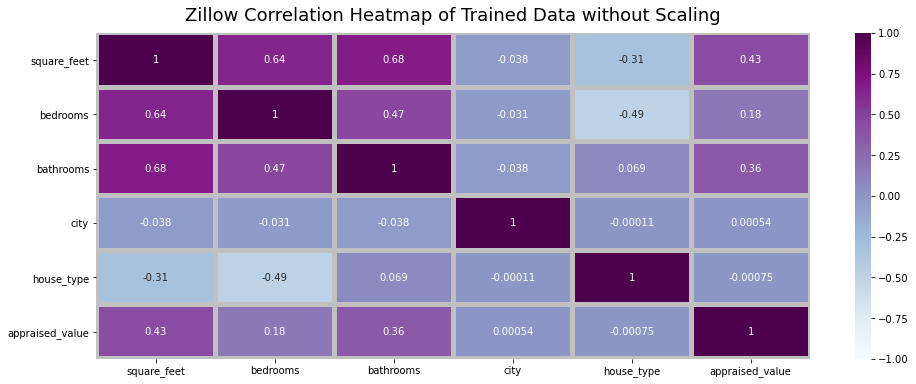

In [25]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.corr(), cmap="BuPu", vmin=-1, vmax=1, annot=True, 
                       center=0, linewidths=4, linecolor='silver')
plt.title('Zillow Correlation Heatmap of Trained Data without Scaling', fontsize=18, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

- In the above chart
    - the darker purple represents a stronger positive correlation between two features
    - the lighter the blue the stronger the negative correlation between 2 features
- The strongest correlations to the `appraise_value` feature are:
    - `square_feet`
        - 0.62
            - positive correlation
    - `bathrooms`
        - 0.53
            - positive correlation
    - `bedrooms`
        - 0.29
            - positive correlation
    - `house_type`
        - -0.1
            - negative correlation


## Correlation Heatmap of Scaled Trained Data

In [26]:
train_scaled, validate_scaled, test_scaled = prepare.scale_focused_zillow(train, validate, test)

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(test)
    
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)

Text(0.5, 1.0, 'Zillow Correlation Heatmap of Scaled Trained Data')

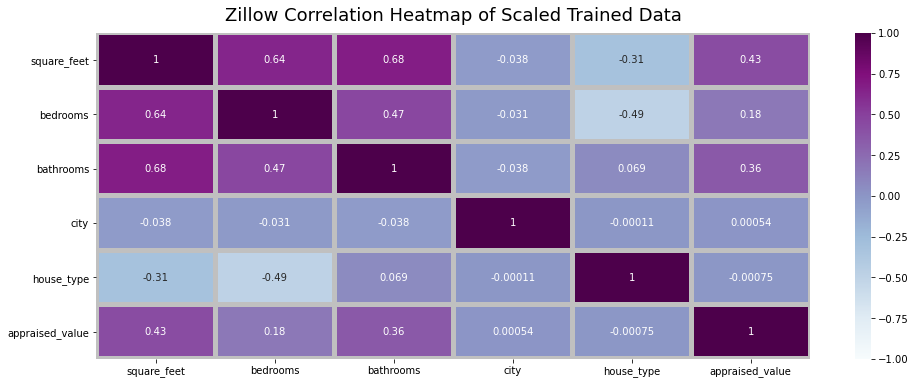

In [27]:
plt.figure(figsize=(16, 6))
sns.heatmap(train_scaled.corr(), cmap="BuPu", vmin=-1, vmax=1, annot=True, 
                       center=0, linewidths=4, linecolor='silver')
plt.title('Zillow Correlation Heatmap of Scaled Trained Data', fontsize=18, pad=12)
# '-' (negative) is still correlation but is downward slope not upward

#### Nothing changed between the not scaled train data set and the scaled train data set

- In the above chart
    - the darker purple represents a stronger positive correlation between two features
    - the lighter the blue the stronger the negative correlation between 2 features
- The strongest correlations to the `appraise_value` feature are:
    - `square_feet`
        - 0.62
            - positive correlation
    - `bathrooms`
        - 0.53
            - positive correlation
    - `bedrooms`
        - 0.29
            - positive correlation
    - `house_type`
        - -0.1
            - negative correlation
    - ` city`
        - -0.022
            - negative correlation

<AxesSubplot:title={'center':'Distribution of Appraised Values'}, xlabel='appraised_value'>

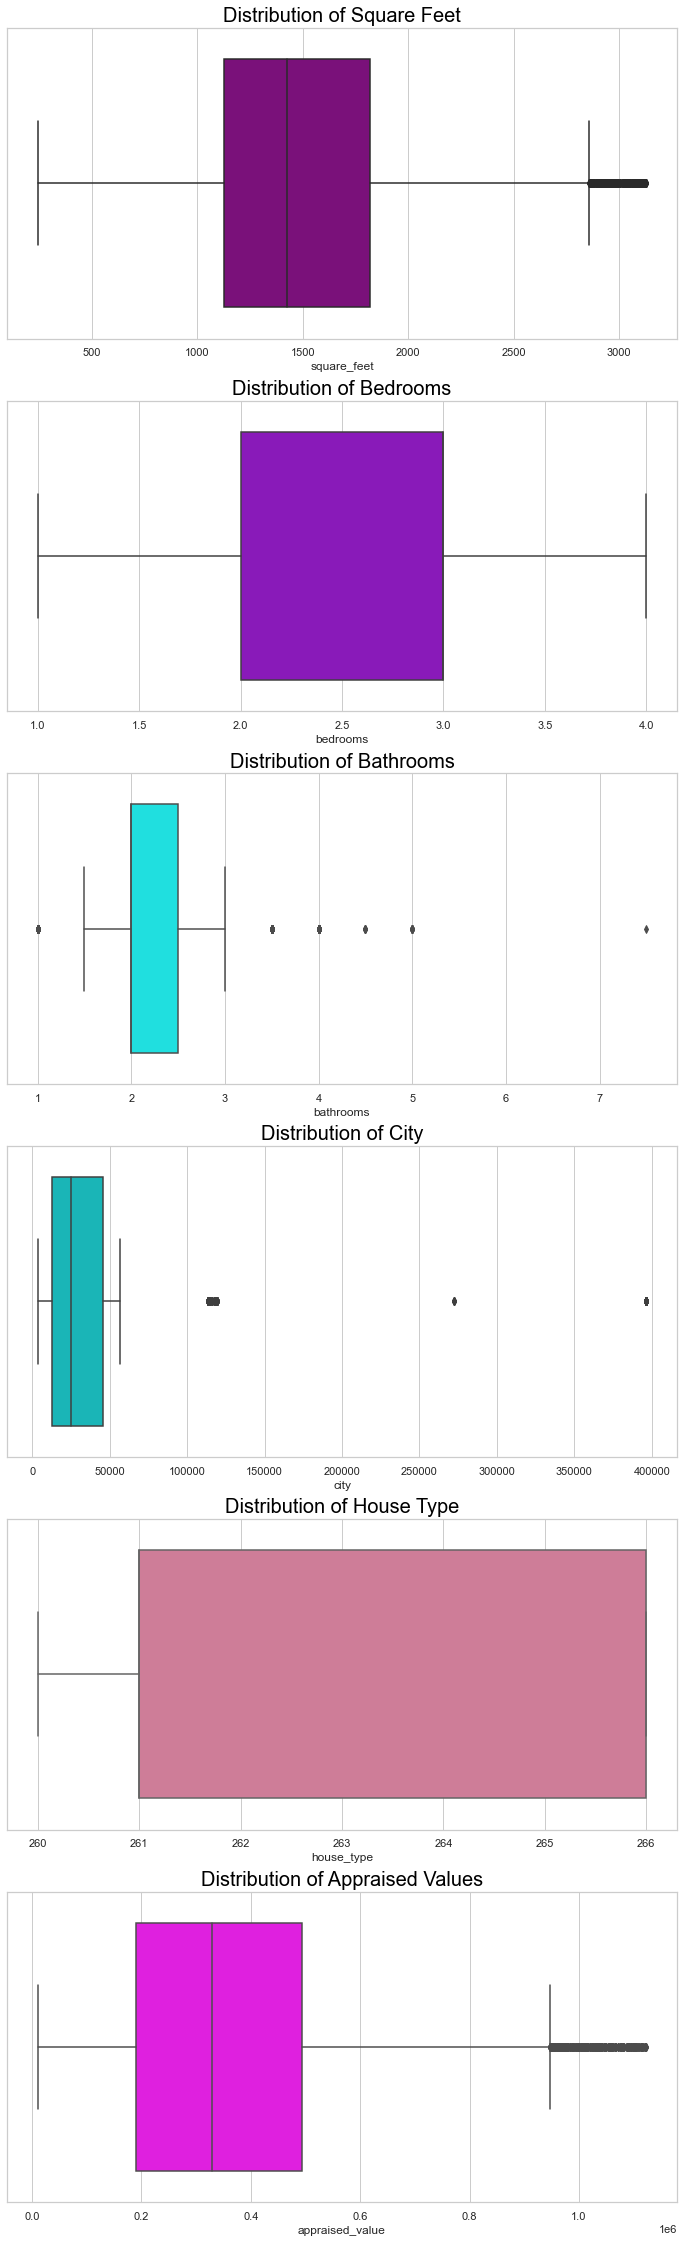

In [28]:
plt.subplots(6, 1, figsize=(12,40), sharey=True)
sns.set(style="whitegrid")

plt.subplot(6,1,1)
plt.title("Distribution of Square Feet", size=20, color='black')
sns.boxplot(train.square_feet, color='darkmagenta')
    
plt.subplot(6,1,2)
plt.title("Distribution of Bedrooms", size=20, color='black')
sns.boxplot(train.bedrooms, color='darkviolet')

plt.subplot(6,1,3)
plt.title("Distribution of Bathrooms", size=20, color='black')
sns.boxplot(train.bathrooms, color='cyan')

plt.subplot(6,1,4)
plt.title("Distribution of City", size=20, color='black')
sns.boxplot(train.city, color='darkturquoise')

plt.subplot(6,1,5)
plt.title("Distribution of House Type", size=20, color='black')
sns.boxplot(train.house_type, color='palevioletred')

plt.subplot(6,1,6)
plt.title("Distribution of Appraised Values", size=20, color='black')
sns.boxplot(train.appraised_value, color='fuchsia')

- Takeaways from boxplots:
    - `appraised_value` has an extreme amount of outliers
        - I will have to remove because they are skewing the data far too much
    - `square_feet` also has too many outliers
        - I will remove these as well because of their affect the data.
    - `bathrooms
        - have some outliers
    - `bedrooms`
        - have some outliers
    - `city`
        - have some outliers
    

- My questions:
    - What is causing these outliers?
        - Are there typos?
            - Probably not this is southern california the state of overpriced housing.
    - How will I go about removing these outliers?
    - Is there anything I should remove from the data?
    

<AxesSubplot:title={'center':'Distribution of Appraised Values'}, xlabel='appraised_value', ylabel='Count'>

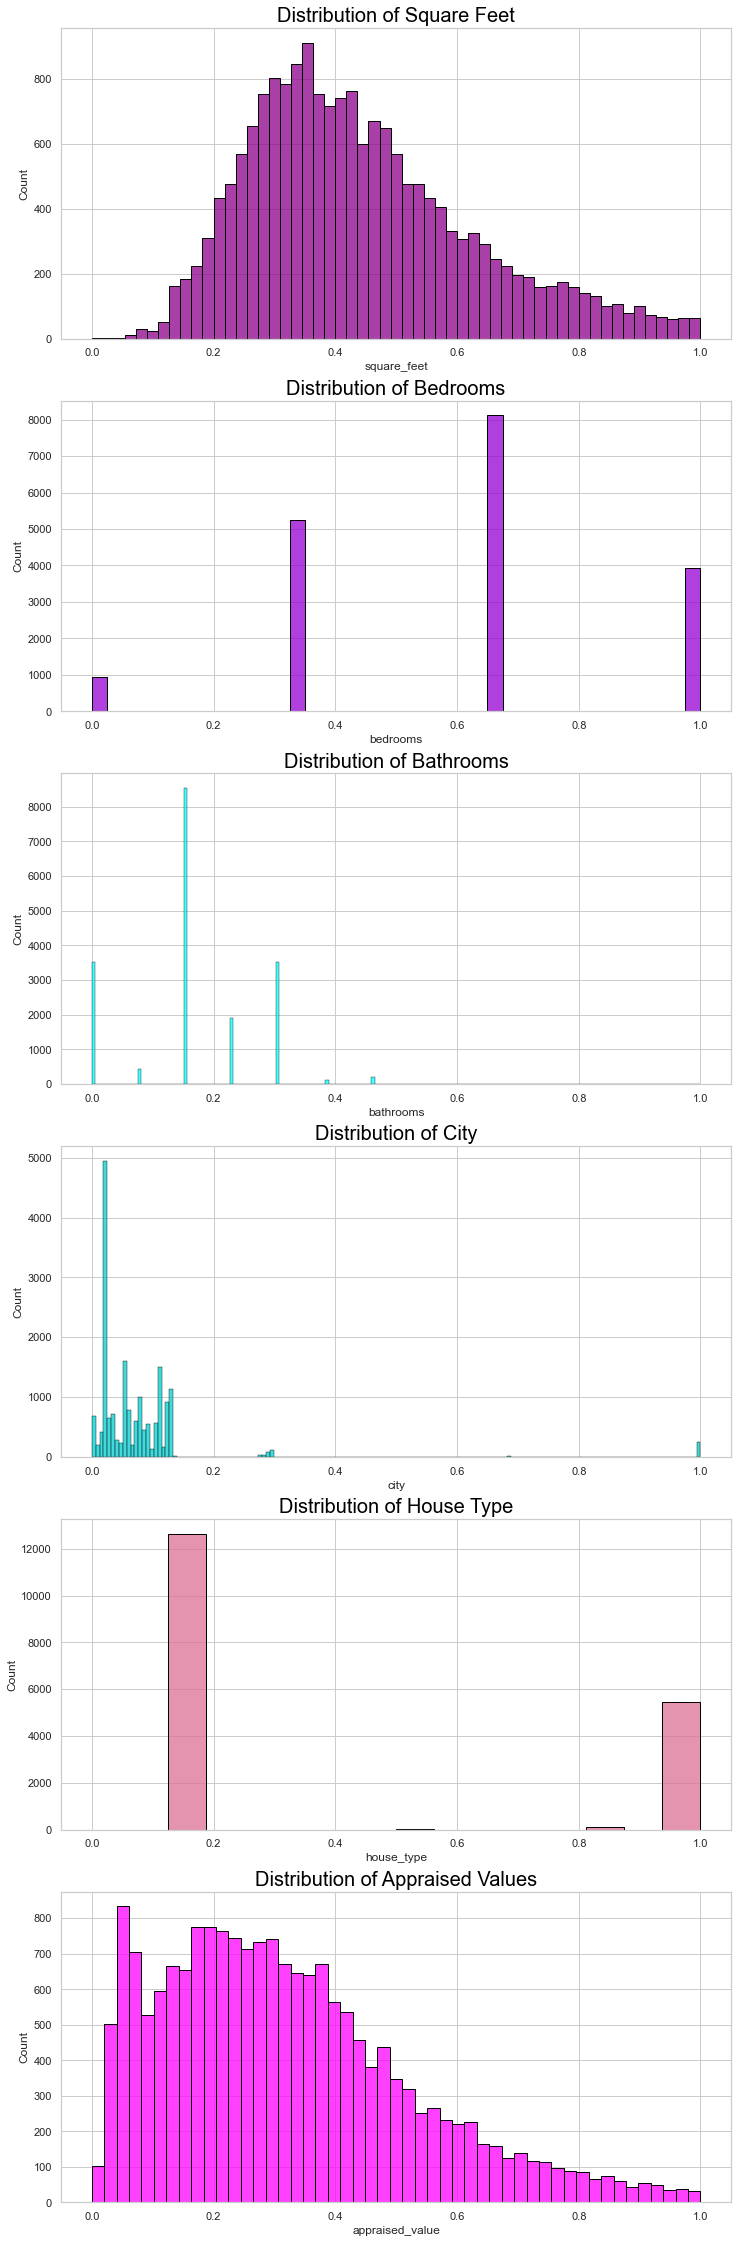

In [29]:
plt.subplots(6, 1, figsize=(12,40), sharey=True)
sns.set(style="whitegrid")

plt.subplot(6,1,1)
plt.title("Distribution of Square Feet", size=20, color='black')
sns.histplot(train_scaled.square_feet, color='darkmagenta', ec='black')
    
plt.subplot(6,1,2)
plt.title("Distribution of Bedrooms", size=20, color='black')
sns.histplot(train_scaled.bedrooms, color='darkviolet', ec='black')

plt.subplot(6,1,3)
plt.title("Distribution of Bathrooms", size=20, color='black')
sns.histplot(train_scaled.bathrooms, color='cyan', ec='black')

plt.subplot(6,1,4)
plt.title("Distribution of City", size=20, color='black')
sns.histplot(train_scaled.city, color='darkturquoise', ec='black')

plt.subplot(6,1,5)
plt.title("Distribution of House Type", size=20, color='black')
sns.histplot(train_scaled.house_type, color='palevioletred', ec='black')

plt.subplot(6,1,6)
plt.title("Distribution of Appraised Values", size=20, color='black')
sns.histplot(train_scaled.appraised_value, color='fuchsia', ec='black')

- Takeaways of Histograms:
    - `square_feet` is heavily skewed right
        - so there are a plenty of outliers that are causing a skew
    - `bedrooms` is slihtly skewed right
        - so there are a few outliers that are causing a skew
    - `bathrooms` is slightly skewed right
        - so there are a few outliers that are causing a skew
    - `appraised_value` is heavily skewed right
        - so there are a plenty of outliers that are causing a skew
    
- Moving Forward:
    - I will definatly remove outliers of:
        - `square_feet`
        - `appraised_value`
    - Take a closer look at the outliers of:
        - `bedrooms`
        - `bathrooms`
    - and make an educated decision on if those outlier need to be removed as well.

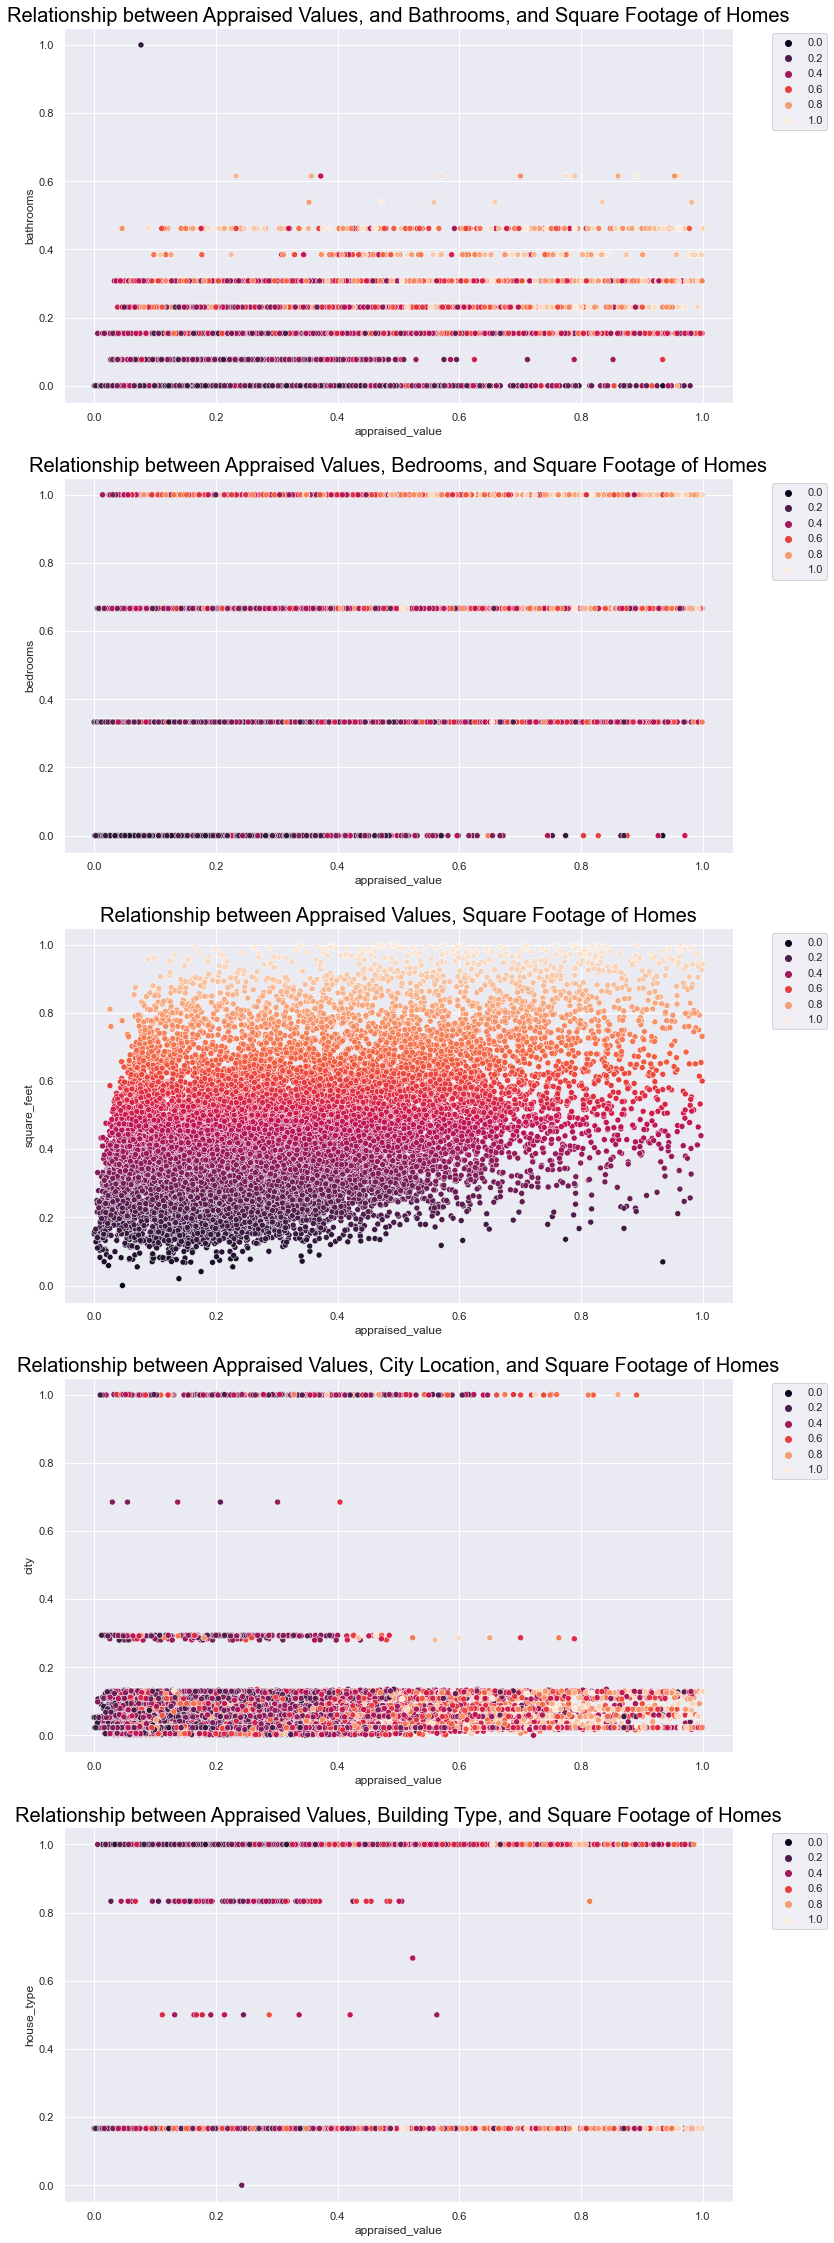

In [30]:
plt.subplots(5, 1, figsize=(12,40), sharey=True)
sns.set(style="darkgrid")

plt.subplot(5,1,1)
plt.title("Relationship between Appraised Values, and Bathrooms, and Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train_scaled, x='appraised_value', y='bathrooms', hue='square_feet', palette='rocket')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
plt.subplot(5,1,2)
plt.title("Relationship between Appraised Values, Bedrooms, and Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train_scaled, x='appraised_value', y='bedrooms', hue='square_feet', palette='rocket')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,3)
plt.title("Relationship between Appraised Values, Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train_scaled, x='appraised_value', y='square_feet', hue='square_feet', palette='rocket')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,4)
plt.title("Relationship between Appraised Values, City Location, and Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train_scaled, x='appraised_value', y='city', hue='square_feet', palette='rocket')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplot(5,1,5)
plt.title("Relationship between Appraised Values, Building Type, and Square Footage of Homes", size=20, color='black')
sns.scatterplot(data=train_scaled, x='appraised_value', y='house_type', hue='square_feet', palette='rocket')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

- Takeaways of Relationship Scatter Plots:
    - I can definatly see a relationship between `appraise_value` and:
        - `square_feet`

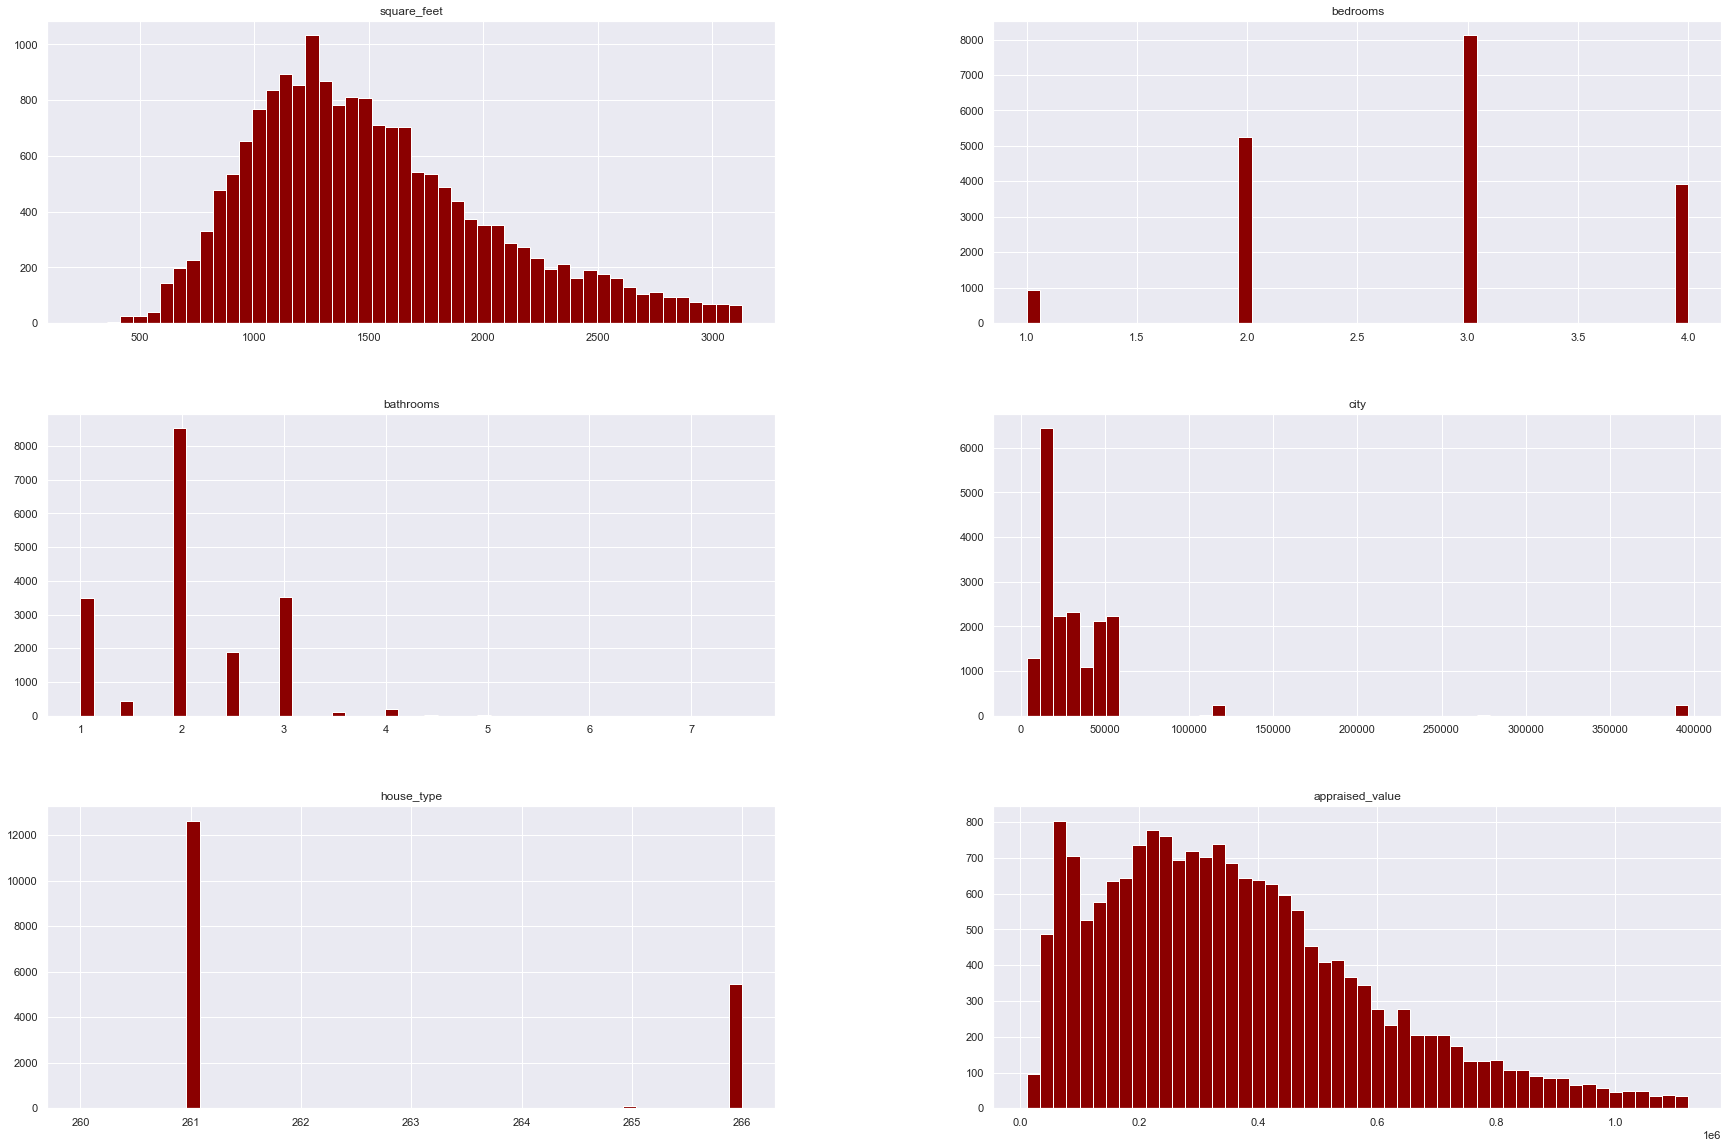

In [31]:
train.hist(bins=50, figsize=(30,20), color='darkred');

## Explore Bathrooms Features

This is a continuous variable so we will be doing a t test

sns.displot(train, x='bathrooms', hue = 'appraised_value')

In [ ]:
sns.displot(train, x=train.bathrooms, hue=train.appraised_value)